In [4]:
import itertools
from copy import deepcopy as copy

import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy

from Span import SpanProgram, sdp_to_span
from Adversary import Adversary, Problem, to_str, visualize
from ElementDistinctness import ED
from Examples import exact_k, threshold_k
from Solvers import adv_solver, span_solver, big_mask_index_disagree, big_mask_index_disagree_type, big_mask_instance

mpl.rcParams["figure.dpi"] = 200

In [5]:
def w_vars_to_W(w_vars, problem):
    n = problem.n
    alpha_len = len(problem.alphabet)
    size = n * alpha_len * d
    w_vars = w_vars.reshape((n, d, problem.yes_len))
    W = np.zeros((n, alpha_len, d, problem.yes_len))
    for yes_index in range(problem.yes_len):
        for j in range(n):
            b = problem.yes_instances[yes_index][j]
            for i in range(d):
                W[j, b, i, yes_index] = w_vars[j, i, yes_index]
    W = W.reshape((size, problem.yes_len))
    return W

def get_no_projection(problem, no, d):
    n = problem.n
    alpha_len = len(problem.alphabet)
    size = n * alpha_len * d
    no_vect = np.zeros((n, alpha_len, d))
    for j in range(len(no)):
        for b in range(alpha_len):
            if b != no[j]:
                for i in range(d): 
                    no_vect[j, b, i] = 1
    no_vect = no_vect.reshape(size)
    no_proj = np.outer(no_vect, no_vect)
    return no_proj
        # no_projections.append(no_proj)
def gen_witness_const_function(problem, d):
    no_projections = []
    n = problem.n
    alpha_len = len(problem.alphabet)
    size = n * alpha_len * d
    ones = np.ones(problem.yes_len)
    for no in problem.no_instances:
        no_projections.append(get_no_projection(problem, no, d))
    def witness_cost(w_vars):
        # w_vars is of shape f^{-1}(1)*n * d
        W = w_vars_to_W(w_vars, problem)
        conjs = [W.T@P@W for P in no_projections]
        conjs_pinv = [np.linalg.pinv(M) for M in conjs]
        # print(conjs_pinv[0])
        W_cost = np.max(np.linalg.norm(W))**2
        W_pinv_cost = np.max(np.array([
            np.linalg.norm(conjs_pinv[i]@ones)**2 for i in range(problem.no_len)
            ]))
        cost = max(W_cost, W_pinv_cost)
        cost +=  10**20*np.max([
            np.linalg.norm(ones - conjs[i]@conjs_pinv[i]@ones, np.inf)**2 for i in range(problem.no_len)
        ])
        return cost
        
    return witness_cost

In [43]:
n= 3
k=2
# d=1
prob = ED(3)
v, X = span_solver(prob, solver_params={"solver": "MOSEK", "verbose": True})
sp = sdp_to_span(X, prob)
d = sp.A.shape[1]//(n * len(prob.alphabet))

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 13 01:12:18 PM: Your problem has 5185 variables, 240 constraints, and 0 parameters.
(CVXPY) Mar 13 01:12:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 13 01:12:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 13 01:12:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 13 01:12:18 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(

24


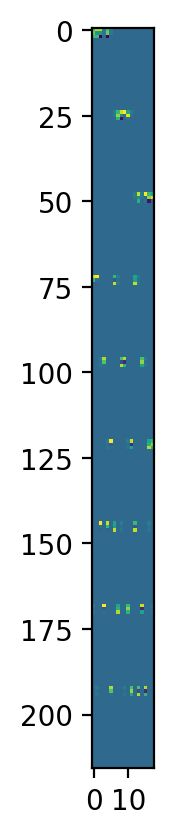

[[1.52260792 0.98833658 0.99033557 0.93601753 1.52364443 0.93368538
  2.96188788 3.4472952  0.82140918 0.90604512 3.18710661 1.08442349
  2.96554034 1.69559397 1.08518853 1.02331878 2.58140248 3.07710086]
 [0.98833658 0.64153692 0.64283448 0.60757622 0.98900939 0.6060624
  1.92258434 2.23766598 0.53318305 0.5881209  2.06877556 0.70390768
  1.92495518 1.10062316 0.70440427 0.66424414 1.67560832 1.99736997]
 [0.99033557 0.64283448 0.64413466 0.60880508 0.99100973 0.60728821
  1.9264729  2.24219182 0.53426145 0.58931042 2.0729598  0.70533138
  1.92884854 1.10284926 0.70582898 0.66558762 1.67899736 2.0014098 ]
 [0.93601753 0.60757622 0.60880508 0.57541327 0.93665472 0.5739796
  1.8208095  2.11921183 0.50495822 0.55698785 1.95926187 0.66664528
  1.82305483 1.04236005 0.66711559 0.62908139 1.58690752 1.89163624]
 [1.52364443 0.98900939 0.99100973 0.93665472 1.52468165 0.93432098
  2.96390417 3.44964193 0.82196835 0.90666191 3.18927622 1.08516171
  2.96755912 1.69674824 1.08592727 1.0240154  

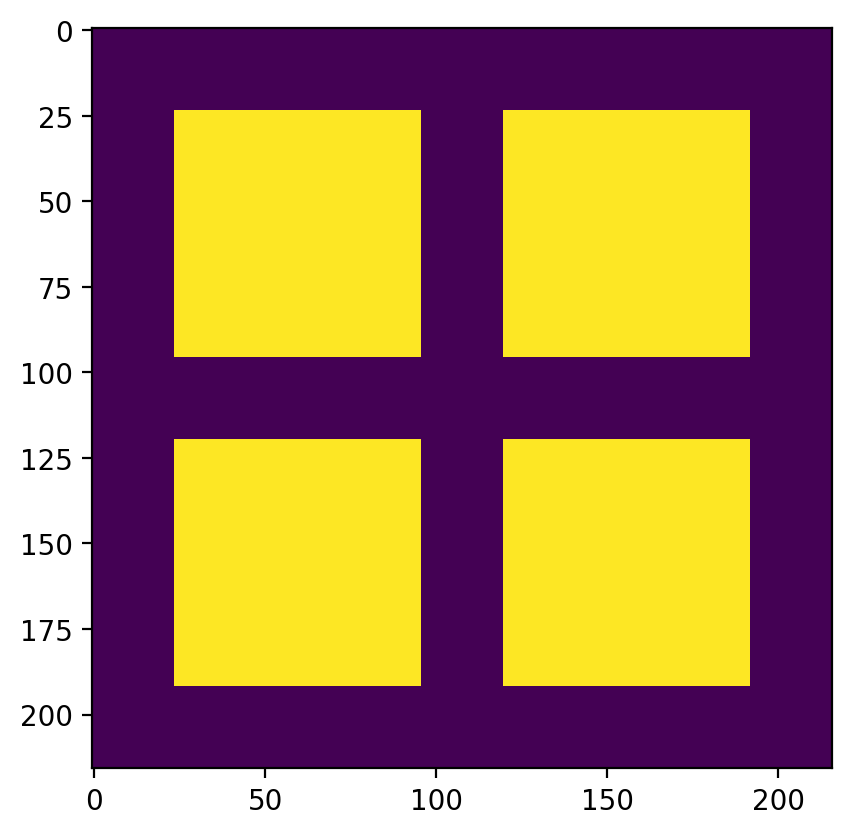

In [46]:
W = np.array(sp.witnesses).T
print(d)
proj = get_no_projection(prob, prob.no_instances[0], d)
# print(proj)
plt.imshow(W)
plt.show()
plt.imshow(proj)
M = W.T@proj@W
print(M)
print(M@np.linalg.pinv(M))
print((M@np.linalg.pinv(M))@np.ones(prob.yes_len))

blah (0, 1, 1)(1, 0, 1)(1, 1, 0)
['011', '101', '110']
['011', '101', '110']
(3, 3)


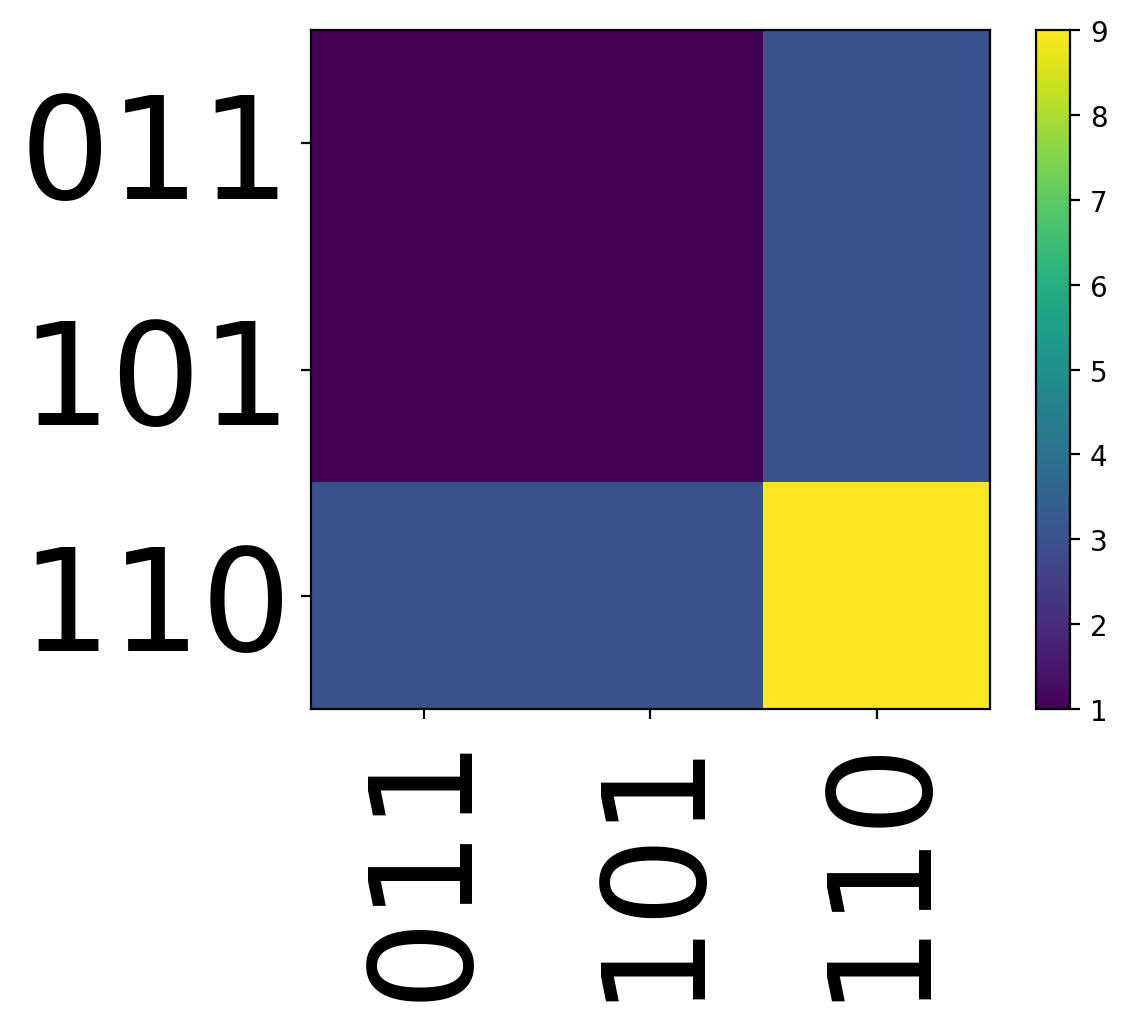

['011', '101', '110']
['011', '101', '110']
(3, 3)


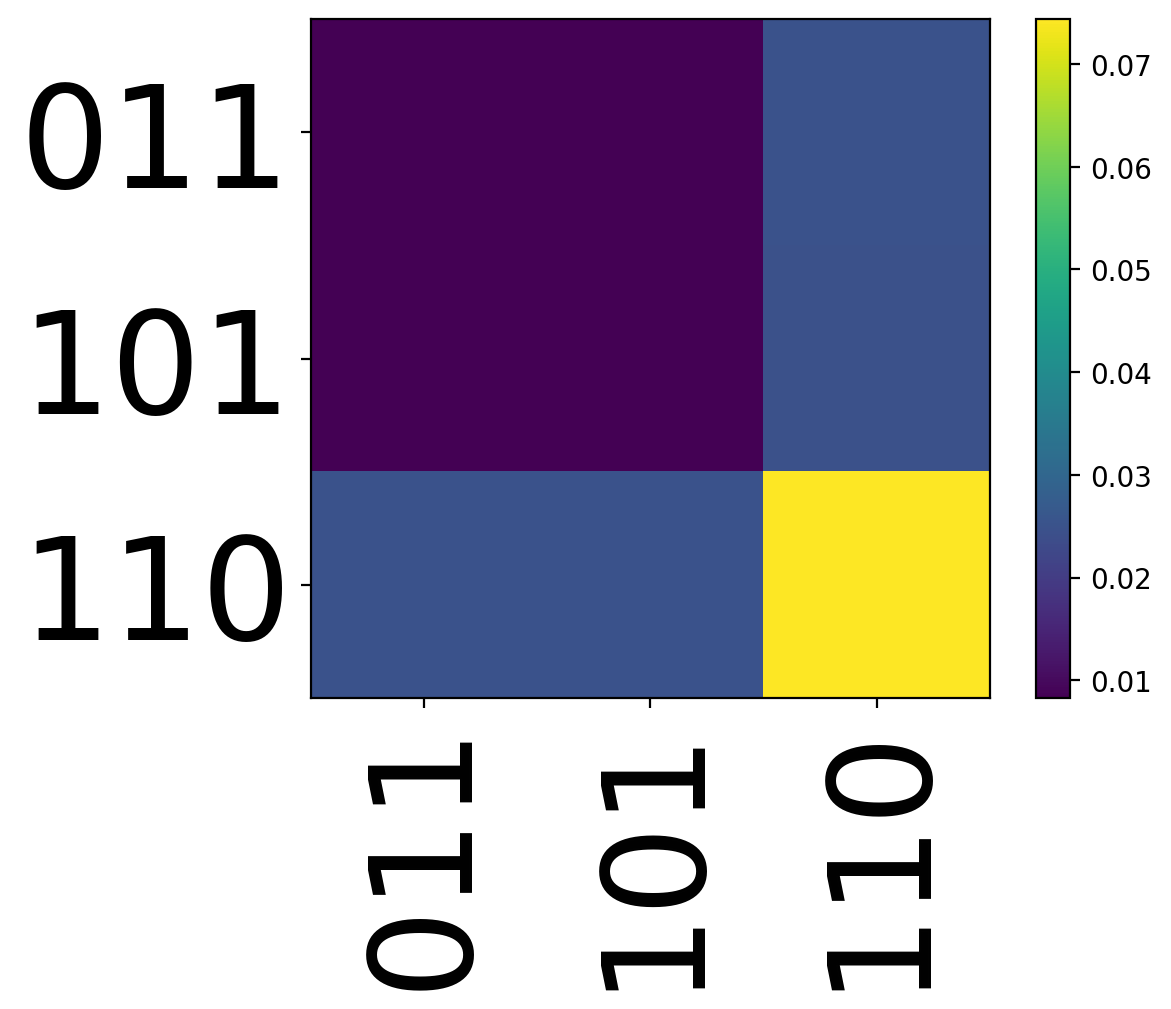

[1]
['011', '101', '110']
(3, 1)


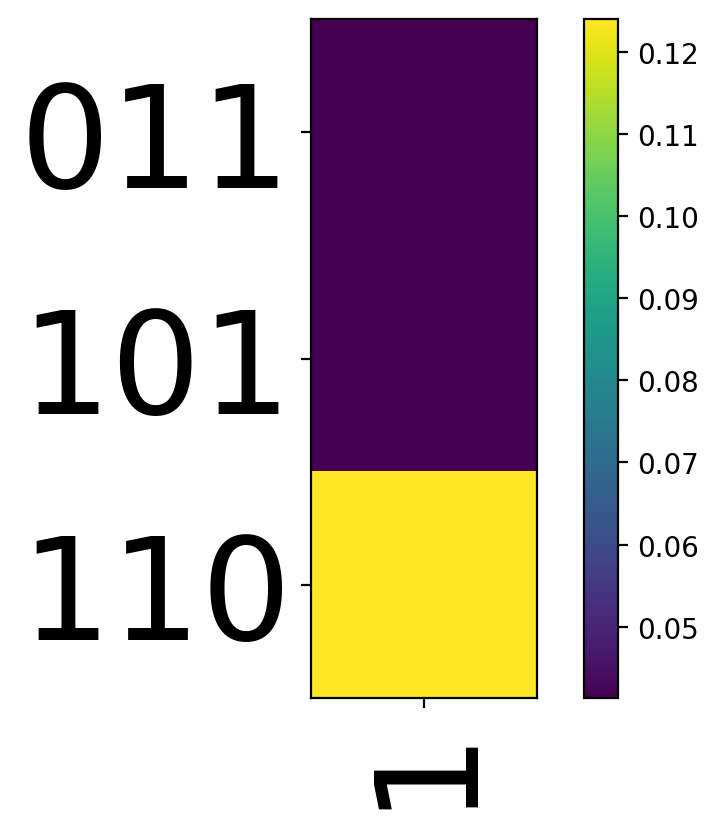

[[0.45454545]
 [0.45454545]
 [1.36363636]]
[0.45454545 0.45454545 1.36363636]


In [15]:
no_proj = get_no_projection(prob, prob.no_instances[0], d)
print("blah", to_str(prob.yes_instances))
yes_str = [to_str(yes) for yes in prob.yes_instances]
M = W.T@no_proj@W
visualize(M, (yes_str, yes_str))
visualize(np.linalg.pinv(M), (yes_str, yes_str))
v_no = (np.linalg.pinv(M)@np.ones((prob.yes_len,1)))
visualize(v_no, ([1], yes_str))
print(M@v_no)
print(np.linalg.pinv(M)@M@np.ones(prob.yes_len))